# CNN Implementation for Cat Breed Classification

This notebook implements a Convolutional Neural Network (CNN) to classify cat breeds.

**Objectives:**
1.  Define a CNN with Batch Normalization and Dropout layers.
2.  Compare the performance of different kernel sizes (e.g., 3x3, 5x5, 7x7).
3.  Select the best kernel size and visualize Training vs. Validation loss and accuracy.

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Data Loading

In [2]:
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10  # Increased slightly to see convergence differences
TARGET_SIZE = (224, 224)

# Data Directories
TRAIN_DIR = 'data/train'
TEST_DIR = 'data/test'

# Transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)

# Data Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Classes: {len(train_dataset.classes)}')
print(f'Training samples: {len(train_dataset)}')
print(f'Testing samples: {len(test_dataset)}')

Classes: 66
Training samples: 18054
Testing samples: 2257


## 2. Model Definition
Includes batch normalization and dropout layers

In [3]:
class CatBreedCNN(nn.Module):
    def __init__(self, num_classes=66, kernel_size=3):
        super(CatBreedCNN, self).__init__()
    
        padding = kernel_size // 2
        
        # Layer 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, padding=padding)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Layer 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Layer 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=kernel_size, padding=padding)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        # Calculate input size for FC layer
        # Input: 224x224
        # After Pool 1: 112x112
        # After Pool 2: 56x56
        # After Pool 3: 28x28
        self.fc_input_size = 128 * 28 * 28
        
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Classifier
        x = x.view(-1, self.fc_input_size)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

## 3. Training Function
Validation tracking during model training

In [7]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS):
    model.to(device)
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    print(f"Training on {device}...")
    epoch_start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_iter_start = time.time()
        
        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}] Training: ", end='', flush=True)
        for batch_idx, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            
            # Print progress every 10 batches
            if batch_idx % 10 == 0 or batch_idx == len(train_loader):
                print(f"[{batch_idx}/{len(train_loader)}]", end=' ', flush=True)
            
        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc = 100 * train_correct / train_total
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        print(f"\nValidating: ", end='', flush=True)
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader, 1):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Print progress every 5 batches
                if batch_idx % 5 == 0 or batch_idx == len(val_loader):
                    print(f"[{batch_idx}/{len(val_loader)}]", end=' ', flush=True)
                
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = 100 * val_correct / val_total
        
        # --- Record History ---
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(avg_train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(avg_val_acc)
        
        # --- Calculate Time Statistics ---
        epoch_time = time.time() - epoch_iter_start
        total_elapsed = time.time() - epoch_start_time
        avg_epoch_time = total_elapsed / (epoch + 1)
        remaining_epochs = num_epochs - (epoch + 1)
        estimated_remaining = avg_epoch_time * remaining_epochs
        
        print(f'\n  Results: Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}% | '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%')
        print(f'  Time: {epoch_time:.1f}s this epoch | '
              f'{total_elapsed/60:.1f}m elapsed | '
              f'{estimated_remaining/60:.1f}m remaining')
              
    return history

## 4. Experiments: Kernel Sizes
Comparing Kernel Sizes: 3, 5, and 7.

In [8]:
kernel_sizes = [3, 5, 7]
results = {}

total_experiments = len(kernel_sizes)
all_experiments_start = time.time()

for exp_idx, k in enumerate(kernel_sizes, 1):
    print(f"\n{'='*60}")
    print(f"EXPERIMENT {exp_idx}/{total_experiments}: Kernel Size = {k}")
    print(f"{'='*60}")
    
    exp_start = time.time()
    
    model = CatBreedCNN(kernel_size=k)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    history = train_and_validate(model, train_loader, test_loader, criterion, optimizer, num_epochs=NUM_EPOCHS)
    results[k] = history
    
    exp_time = time.time() - exp_start
    total_elapsed = time.time() - all_experiments_start
    avg_time_per_exp = total_elapsed / exp_idx
    remaining_exps = total_experiments - exp_idx
    estimated_remaining = avg_time_per_exp * remaining_exps
    
    print(f"\n{'='*60}")
    print(f"Experiment {exp_idx} Complete!")
    print(f"  This experiment: {exp_time/60:.1f}m")
    print(f"  Total elapsed: {total_elapsed/60:.1f}m")
    if remaining_exps > 0:
        print(f"  Estimated remaining: {estimated_remaining/60:.1f}m")
    print(f"{'='*60}")


EXPERIMENT 1/3: Kernel Size = 3
Training on cpu...

Epoch [1/10] Training: [10/565] [20/565] [30/565] [40/565] [50/565] [60/565] [70/565] [80/565] [90/565] [100/565] [110/565] [120/565] [130/565] [140/565] [150/565] [160/565] [170/565] [180/565] [190/565] [200/565] [210/565] [220/565] [230/565] [240/565] [250/565] [260/565] [270/565] [280/565] [290/565] [300/565] [310/565] [320/565] [330/565] [340/565] [350/565] [360/565] [370/565] [380/565] [390/565] [400/565] [410/565] [420/565] [430/565] [440/565] [450/565] [460/565] [470/565] [480/565] [490/565] [500/565] [510/565] [520/565] [530/565] [540/565] [550/565] [560/565] [565/565] 
Validating: [5/71] [10/71] [15/71] [20/71] [25/71] [30/71] [35/71] [40/71] [45/71] [50/71] [55/71] [60/71] [65/71] [70/71] [71/71] 
  Results: Train Loss: 5.0867, Train Acc: 1.58% | Val Loss: 4.1514, Val Acc: 2.61%
  Time: 465.2s this epoch | 7.8m elapsed | 69.8m remaining

Epoch [2/10] Training: [10/565] [20/565] [30/565] [40/565] [50/565] [60/565] [70/565] [

## 5. Results & Visualization

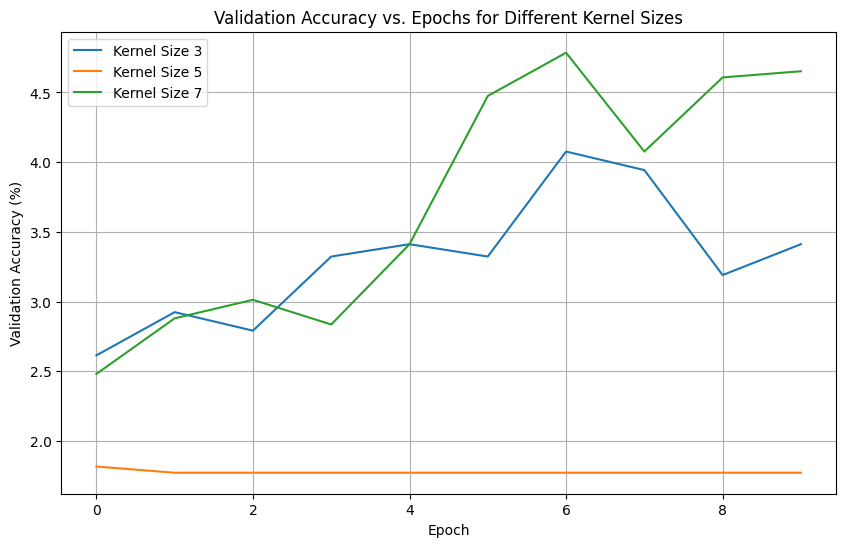


Best Kernel Size based on max validation accuracy: 7


In [10]:
# comparing kernel sizes based on validation accuracy
plt.figure(figsize=(10, 6))
for k in kernel_sizes:
    plt.plot(results[k]['val_acc'], label=f'Kernel Size {k}')
plt.title('Validation Accuracy vs. Epochs for Different Kernel Sizes')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# find best kernel size
best_k = max(results, key=lambda k: max(results[k]['val_acc']))
print(f"\nBest Kernel Size based on max validation accuracy: {best_k}")

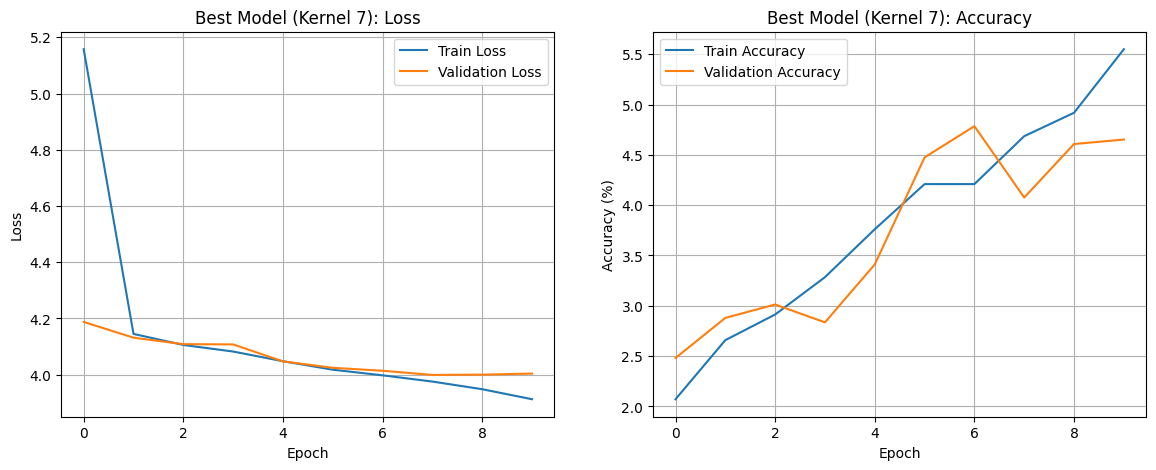

In [11]:
# plot best model loss and accuracy
best_history = results[best_k]

plt.figure(figsize=(14, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(best_history['train_loss'], label='Train Loss')
plt.plot(best_history['val_loss'], label='Validation Loss')
plt.title(f'Best Model (Kernel {best_k}): Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# accuracy
plt.subplot(1, 2, 2)
plt.plot(best_history['train_acc'], label='Train Accuracy')
plt.plot(best_history['val_acc'], label='Validation Accuracy')
plt.title(f'Best Model (Kernel {best_k}): Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()